<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 0. Data preparation

In [47]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [49]:
len(trainloader)

391

## 1. Custom Convolutional model

Попробуем написать свою собственную маленькую конволюционную модель

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [4]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [5]:
import torchsummary

In [6]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]           5,770
              ReLU-4           [-1, 10, 28, 28]               0
           Flatten-5                 [-1, 7840]               0
            Linear-6                   [-1, 10]          78,410
Total params: 85,972
Trainable params: 85,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 0.33
Estimated Total Size (MB): 1.40
----------------------------------------------------------------


## 2. Write train and test function

In [7]:
dataiter = iter(trainloader)
data = next(dataiter)

In [8]:
data[0][0], data[1][0]

(tensor([[[0.5950, 0.5950, 0.6725,  ..., 0.8082, 0.7501, 0.8276],
          [0.5368, 0.6531, 0.6919,  ..., 0.7113, 0.6338, 0.6919],
          [0.5368, 0.7888, 0.8470,  ..., 0.7888, 0.6531, 0.6144],
          ...,
          [0.3430, 0.3624, 0.4011,  ..., 0.8082, 0.8664, 0.7888],
          [0.4011, 0.3624, 0.3817,  ..., 0.9051, 0.8470, 0.7501],
          [0.5562, 0.5174, 0.4787,  ..., 0.9633, 0.9245, 0.9439]],
 
         [[0.8661, 0.9251, 1.0234,  ..., 1.2201, 1.1611, 1.2398],
          [0.8268, 0.9448, 0.9841,  ..., 1.1218, 1.0431, 1.1021],
          [0.8661, 1.0431, 1.0431,  ..., 1.1808, 1.0628, 1.0234],
          ...,
          [0.7481, 0.7874, 0.7874,  ..., 1.1414, 1.2201, 1.1611],
          [0.8268, 0.7874, 0.7874,  ..., 1.2201, 1.1414, 1.0824],
          [0.9054, 0.8661, 0.8268,  ..., 1.2594, 1.2201, 1.2594]],
 
         [[0.8222, 0.9198, 1.0563,  ..., 1.1539, 1.0954, 1.1734],
          [0.8222, 0.9978, 1.0954,  ..., 1.0758, 0.9783, 1.0368],
          [0.8807, 1.1539, 1.2514,  ...,

5


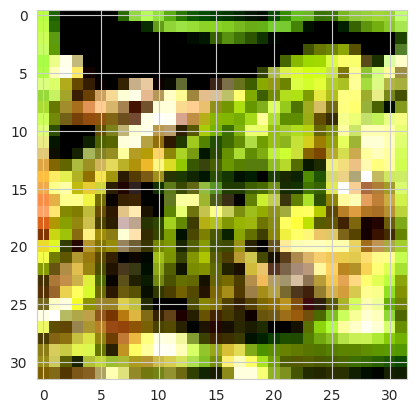

----------------------------------------------------------------------------------------------------
8


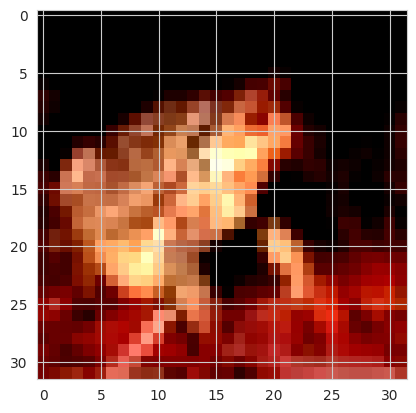

----------------------------------------------------------------------------------------------------


In [9]:
def imshow(img):
  img = img / 2 + 0.5   # unnormalize
  npimg = img.numpy()   # convert from tensor
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

for i in range(10):  # show just the frogs
  if data[1][i] == 6:  # 6 = frog
    print(i)
    imshow(torchvision.utils.make_grid(data[0][i]))
    print('-'*100)

In [29]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [30]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)

            test_loss += loss.item()
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]

    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))

    return test_loss / total, acc


## 3. Train Model

In [31]:
from IPython.display import clear_output
import numpy as np

In [32]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

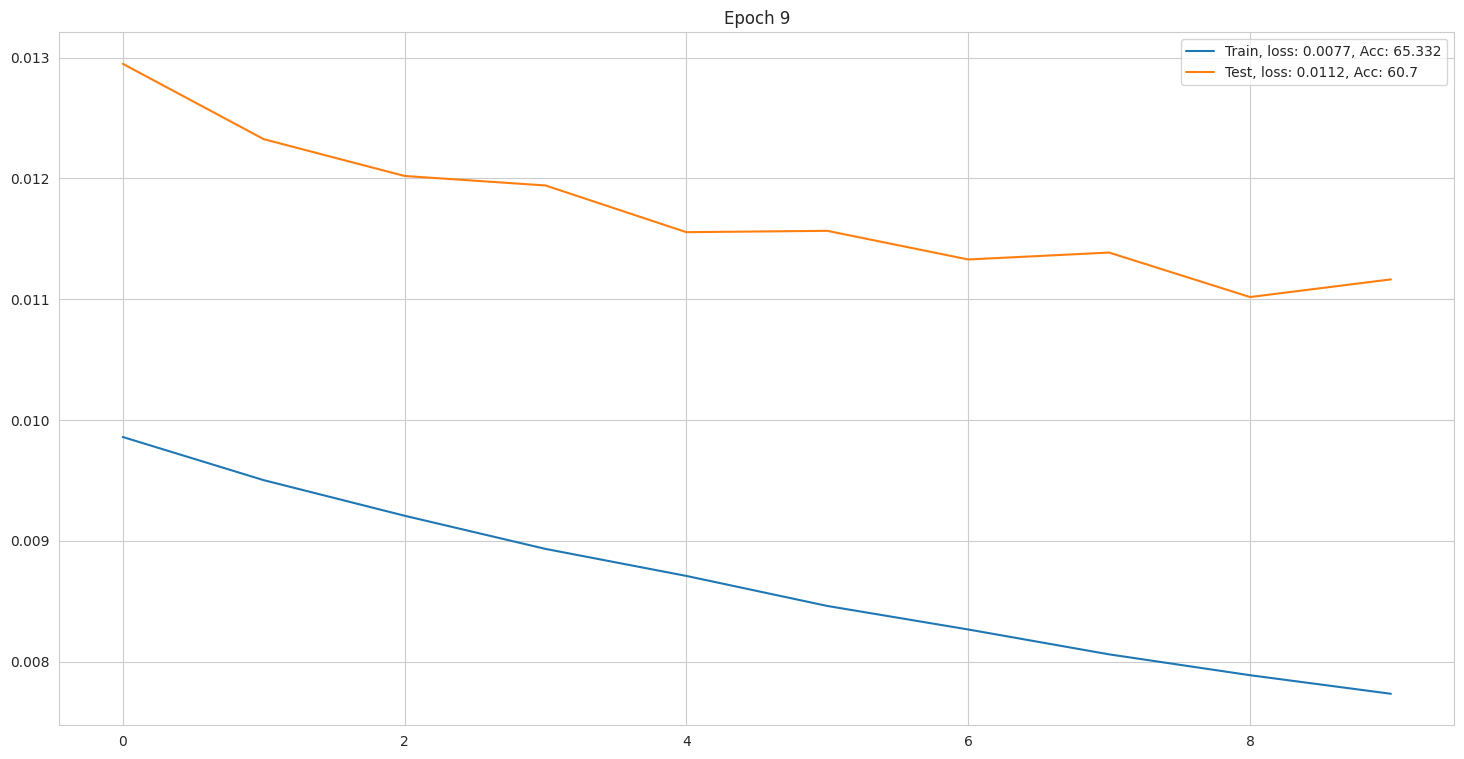

In [33]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [34]:
best_acc

61.19

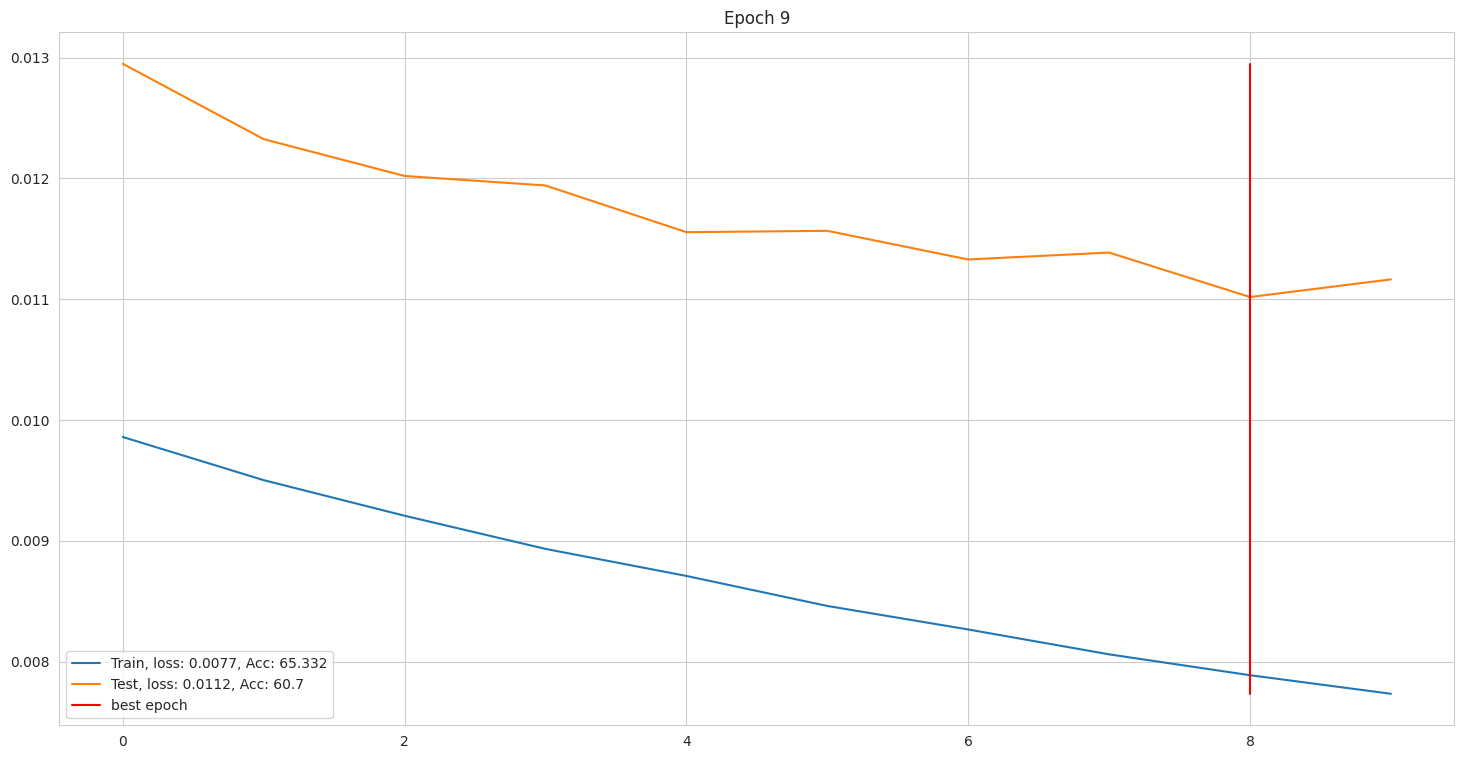

In [35]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

### BatchNorm

https://arxiv.org/abs/1502.03167

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png)

In [36]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [37]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
            Conv2d-4           [-1, 10, 28, 28]           5,770
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
           Flatten-7                 [-1, 7840]               0
            Linear-8                   [-1, 10]          78,410
Total params: 86,120
Trainable params: 86,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.56
Params size (MB): 0.33
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


In [38]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

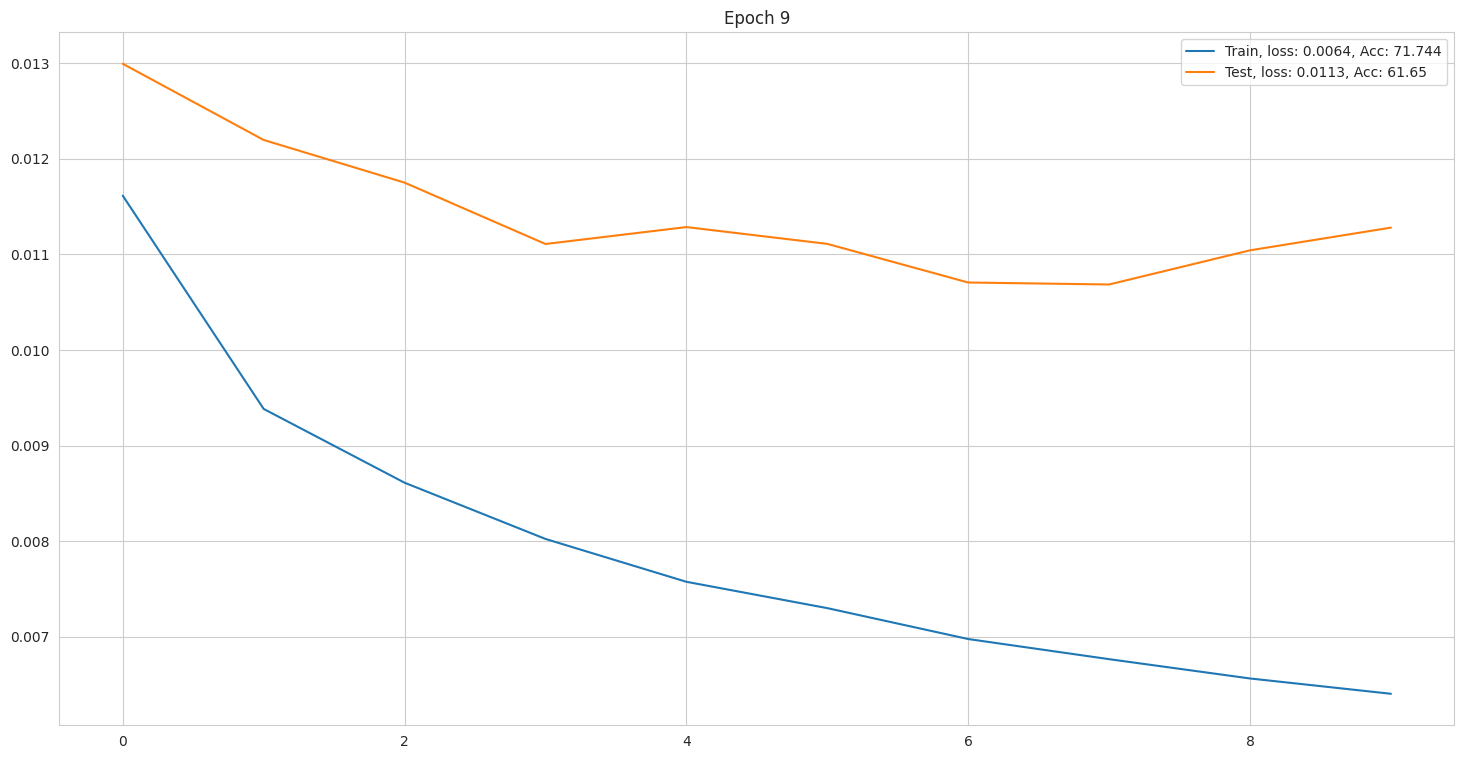

In [39]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'with_bn')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [40]:
best_acc

63.37

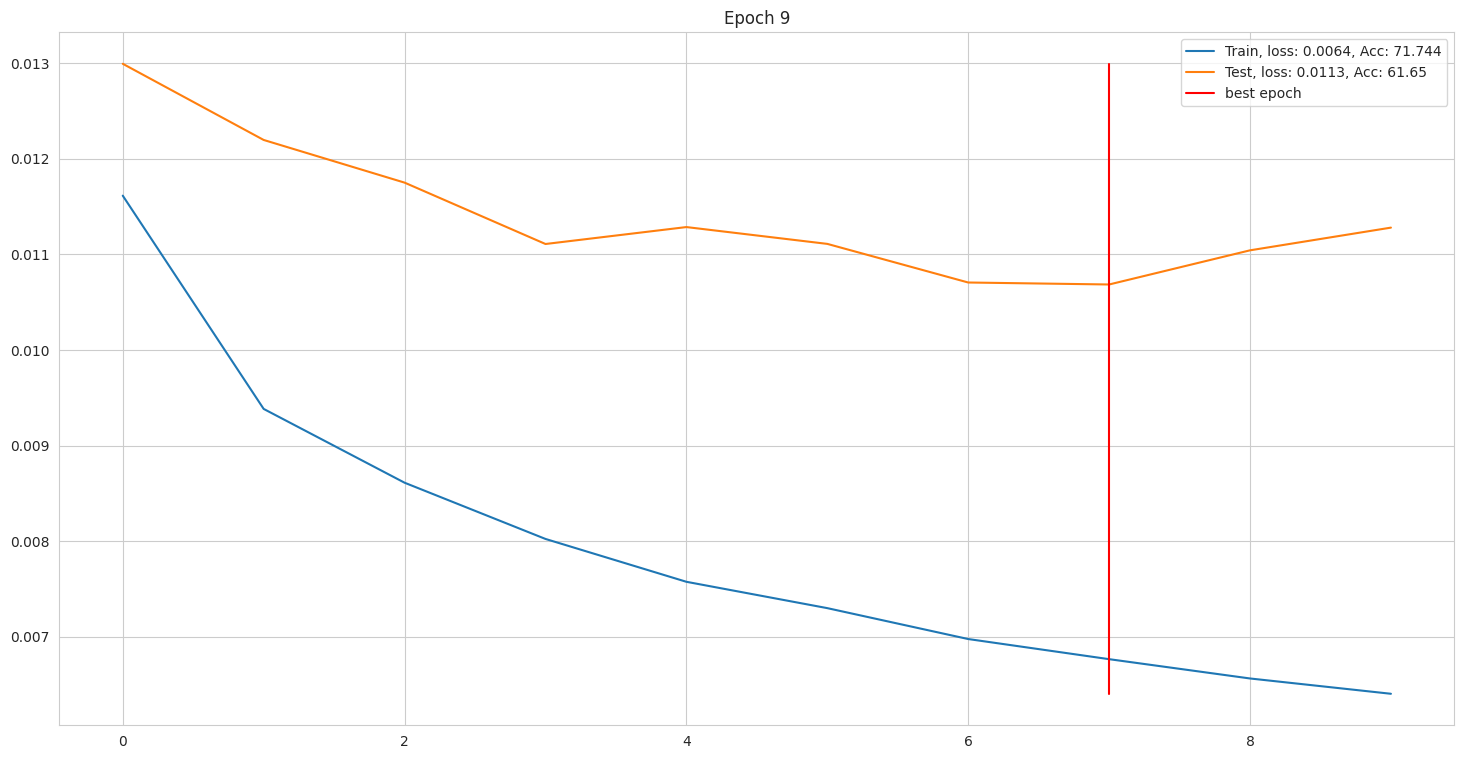

In [41]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

## 4. Add some augmentations

https://pytorch.org/docs/stable/torchvision/transforms.html

Добавим пару аугментаций (`Crop` & `Flip`) и посмотрим, как изменится обучение

In [50]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # изменение настроек изображения
    transforms.RandomRotation(25), # повороты изоражений
    transforms.RandomHorizontalFlip(), # отзеркаливание избражений
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [53]:
def train(model, optim, criterion, dataloader, epoch, device, add_noise=True):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        if add_noise:
            data = data + torch.empty(*data.size()).normal_(0, 0.0001)
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [54]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

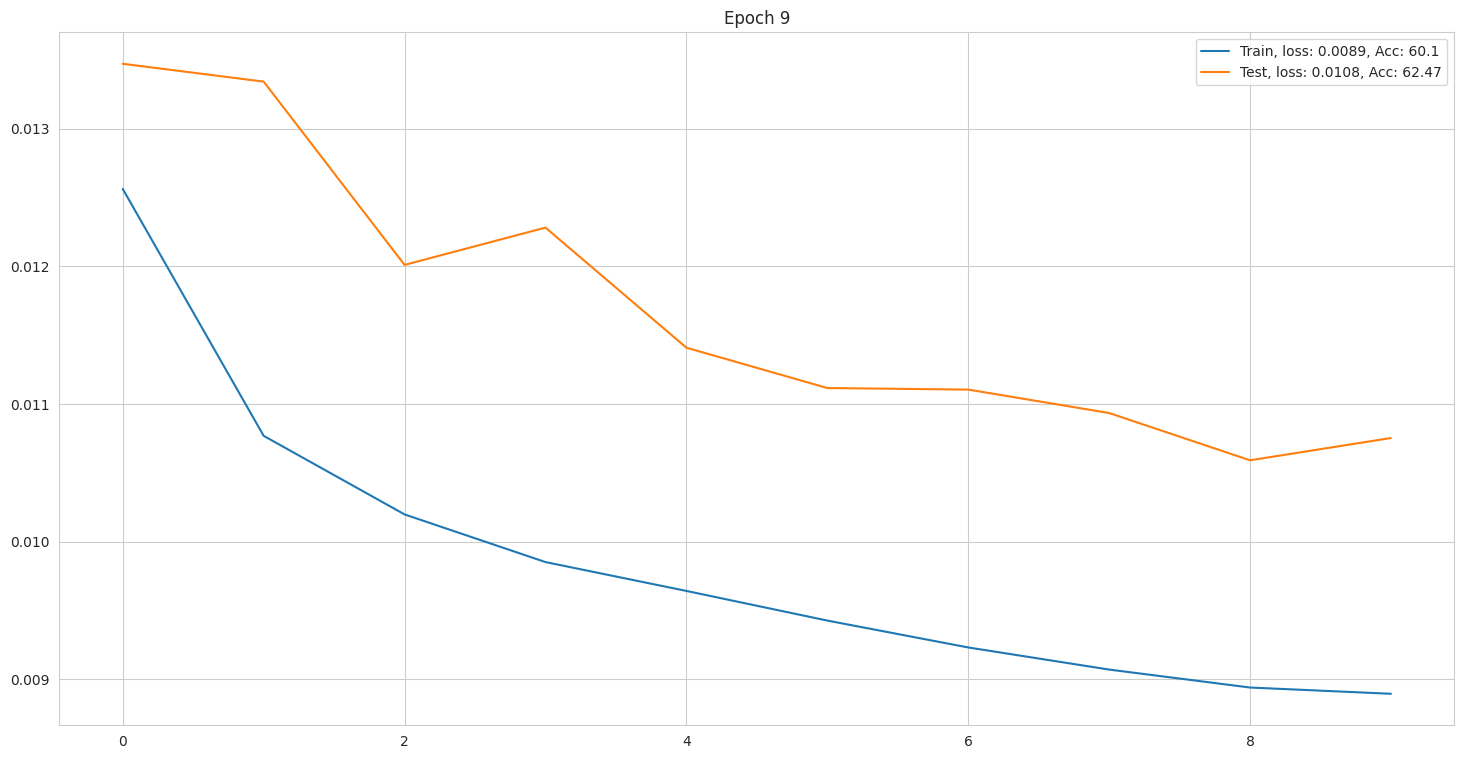

In [55]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'bn_and_aug')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()